<a href="https://colab.research.google.com/github/chang-heekim/ResidualNetwork-for-Cifar10/blob/main/Tensorflow_ResidualNetwork_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, ReLU

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 7s 0us/step


In [3]:
train_batch_size = 128
val_batch_size = 64
test_batch_size = 128

train_images = train_images / 255.
test_images = test_images / 255.

train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

train_size = int(len(train_images) * 0.9)
val_size = len(train_images) - train_size

dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(1024)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = dataset.take(train_size)
val_dataset = dataset.take(val_size)

train_dataset = train_dataset.batch(train_batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(val_batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(test_batch_size, drop_remainder=True)

In [4]:
for sample_batch in train_dataset:
    print(sample_batch)
    print(sample_batch[0].shape)
    break

(<tf.Tensor: shape=(128, 32, 32, 3), dtype=float64, numpy=
array([[[[0.08627451, 0.07843137, 0.07843137],
         [0.24705882, 0.20784314, 0.21960784],
         [0.31764706, 0.25882353, 0.27843137],
         ...,
         [0.3254902 , 0.20392157, 0.23529412],
         [0.29411765, 0.2       , 0.25490196],
         [0.21568627, 0.15686275, 0.20392157]],

        [[0.15686275, 0.12156863, 0.13333333],
         [0.31372549, 0.24313725, 0.26666667],
         [0.36078431, 0.26666667, 0.29411765],
         ...,
         [0.35294118, 0.23921569, 0.2745098 ],
         [0.36862745, 0.24705882, 0.29803922],
         [0.34117647, 0.25098039, 0.29019608]],

        [[0.1372549 , 0.08627451, 0.10196078],
         [0.27843137, 0.19607843, 0.22352941],
         [0.32156863, 0.20784314, 0.23921569],
         ...,
         [0.35686275, 0.24705882, 0.28627451],
         [0.48627451, 0.32941176, 0.37647059],
         [0.46666667, 0.3372549 , 0.37254902]],

        ...,

        [[0.12941176, 0.09019608,

In [5]:
classes = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

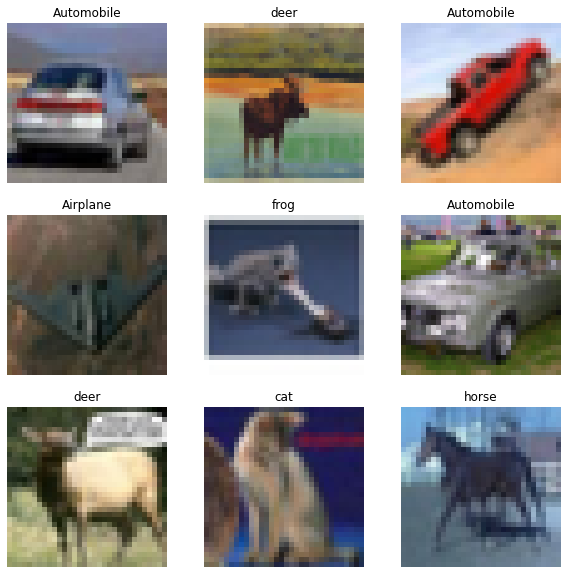

In [6]:
sample = next(iter(train_dataset))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample[0][i])
    plt.axis('off')
    plt.title(classes[sample[1][i].numpy()])
plt.show()

In [7]:
class BasicBlock(tf.keras.Model):
    def __init__(self, filter_in, filter_out, stride):
        super().__init__()

        self.conv1 = Conv2D(filter_out, kernel_size=3, strides=stride, padding='same')
        self.bn1 = BatchNormalization()

        self.conv2 = Conv2D(filter_out, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()

        if stride == 2:
            self.identity = Conv2D(filter_out, kernel_size=1, strides=stride, padding='same')
        else:
            self.identity = lambda x: x

    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = tf.nn.relu(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = tf.nn.relu(out)
        out += self.bn3(self.identity(x), training=training)
        return out

class BottleNeck(tf.keras.Model):
    def __init__(self, filter_in, filter_out, stride, expansion=4):
        super().__init__()

        self.conv1 = Conv2D(filter_out, kernel_size=1, strides=stride, padding='same')
        self.bn1 = BatchNormalization()

        self.conv2 = Conv2D(filter_out, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()

        self.conv3 = Conv2D(filter_out * expansion, kernel_size=1, padding='same')
        self.bn3 = BatchNormalization()
        self.bn4 = BatchNormalization()

        if stride == 2 or filter_in != filter_out * expansion:
            self.identity = Conv2D(filter_out * expansion, 1, strides=stride, padding='same')
        else:
            self.identity = lambda x: x
    
    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = tf.nn.relu(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = tf.nn.relu(out)
        out = self.conv3(out)
        out = self.bn3(out, training=training)
        out = tf.nn.relu(out)
        out += self.bn4(self.identity(x), training=training)

        return out


class ResNet(tf.keras.Model):
    def __init__(self, block, num_blocks):
        super().__init__()
        self.filter_in = 64

        self.conv1 = Conv2D(64, kernel_size=7, strides=2, padding='same')
        self.bn1= BatchNormalization()
        self.maxpool1 = MaxPool2D(3, 2)

        self.layer1 = self.residual_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.residual_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.residual_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.residual_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = tf.keras.layers.AveragePooling2D((1,1))
        self.flatten = tf.keras.layers.Flatten()
        self.dense = Dense(10, activation='softmax')

    def residual_layer(self, block, filter_out, num_block, stride):
        strides = [stride] + [1] * (num_block - 1)
        layers = tf.keras.Sequential()
        for stride in strides:
            layers.add(block(self.filter_in, filter_out, stride))
            self.filter_in = filter_out * 4
        return layers

    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)

        out = self.flatten(out)
        out = self.dense(out)
        return out

In [8]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [9]:
model = ResNet50()
model.build((None, 32, 32, 3))
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 7, 7, 256)         222080    
                                                                 
 sequential_1 (Sequential)   (None, 4, 4, 512)         1236480   
                                                                 
 sequential_2 (Sequential)   (None, 2, 2, 1024)        7149

In [10]:
save_path = '/content/runs/checkpoints'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [12]:
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[checkpoint]
)

Epoch 1/50
351/351 [==============================] - ETA: 0s - loss: 1.6999 - accuracy: 0.4587
Epoch 00001: val_loss improved from inf to 2.01201, saving model to /content/runs/checkpoints
INFO:tensorflow:Assets written to: /content/runs/checkpoints/assets
351/351 [==============================] - 69s 157ms/step - loss: 1.6999 - accuracy: 0.4587 - val_loss: 2.0120 - val_accuracy: 0.3019
Epoch 2/50
351/351 [==============================] - ETA: 0s - loss: 1.3902 - accuracy: 0.5420
Epoch 00002: val_loss improved from 2.01201 to 1.87621, saving model to /content/runs/checkpoints
INFO:tensorflow:Assets written to: /content/runs/checkpoints/assets
351/351 [==============================] - 54s 155ms/step - loss: 1.3902 - accuracy: 0.5420 - val_loss: 1.8762 - val_accuracy: 0.3782
Epoch 3/50
351/351 [==============================] - ETA: 0s - loss: 1.3326 - accuracy: 0.5637
Epoch 00003: val_loss did not improve from 1.87621
351/351 [==============================] - 21s 61ms/step - loss: 

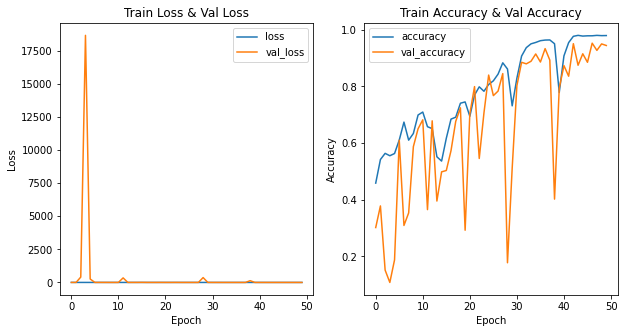

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Train Loss & Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.title('Train Accuracy & Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

78/78 [==============================] - 3s 23ms/step - loss: 1.6375 - accuracy: 0.7163
Test Loss: 1.637521505355835, Test Accuracy: 0.7163461446762085
